This code is adapted from [kaggle notebook Semantic Segmentation is easy](https://https://www.kaggle.com/code/ligtfeather/semantic-segmentation-is-easy-with-pytorch)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


OK. I am putting 8955_2023_image1.png and its mask to the location for histosegnet data

In [ ]:
!pip install segmentation-models-pytorch --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 961.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 12.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import albumentations as A
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn.functional import normalize
import torchvision.transforms as transforms

In [ ]:
import tifffile
from PIL import Image
import cv2

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import time
import os
from tqdm.notebook import tqdm


I am creating a folder for original images and their masks, after augmentation. This is made of slides from histosegnet data and few NVU slides which I annotated myself.

In [ ]:
rm *.png

In [ ]:
!cp *.png /content/drive/MyDrive/histoSegNet_data/img/01_tuning_patch/all_images/

In [ ]:
!cp *.png /content/drive/MyDrive/histoSegNet_data/gt/01_tuning_patch/morph/all_images/

I have transferred all the self annotated images to the common folder

In [ ]:
# access google drive
IMAGE_PATH = '/content/drive/MyDrive/histoSegNet_data/img/01_tuning_patch/all_images/'
len(os.listdir(IMAGE_PATH))

56

In [ ]:
MASK_PATH = '/content/drive/MyDrive/histoSegNet_data/gt/01_tuning_patch/morph/all_images/'
len(os.listdir(MASK_PATH))

56

We have to now frame the dataset class for our images

In [ ]:
n_classes = 20

def create_df():
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            name.append(filename[:-4])

    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df = create_df()
print('Total Images: ', len(df))

Total Images:  56


In [ ]:
df.head()

,id
0,BC3.png_crop_1858
1,070.png_crop_1432
2,146_R03.png_crop_5
3,161.png_crop_1306
4,008.png_crop_3788


In [ ]:
#split data
X_train, X_test = train_test_split(df['id'].values, test_size=0.1, random_state=19)

print('Train Size   : ', len(X_train))
print('Test Size    : ', len(X_test))

Train Size   :  50
Test Size    :  6


In [ ]:
df['id'][40]

'PP27.png_crop_270'

Image Size (224, 224, 3)
Mask Size (1088, 1088, 4)


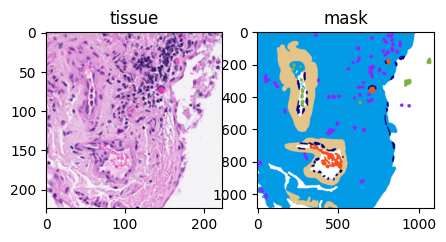

In [ ]:
img = Image.open(IMAGE_PATH + df['id'][40] + '.png')
mask = Image.open(MASK_PATH + df['id'][40] + '.png')
print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)

fig,ax = plt.subplots(1,2,figsize = (5,5))
ax = ax.ravel()
ax[0].imshow(img)
ax[0].set_title('tissue')
ax[1].imshow(mask)
ax[1].set_title('mask')
plt.show()


### DATASET

### we have to map all the classes in the mask and limit it to 20 classes

In [ ]:
class SlideAugmentDataset(Dataset):

  """we are returning integer dtype numpy arrays here to be used
    as input for Albumentations library. The input images are from
    HistoSegNet database and 5 images from my NVU dataset"""

  def __init__(self, img_path, mask_path, X):
      self.img_path = img_path
      self.mask_path = mask_path
      self.X = X

  def __len__(self):
      return len(self.X)

  def __getitem__(self, idx):
      img_x = 640 # divisible by 32 for the CNN to work
      img_y = 640 # divisible by 32 for hte CNN to work
      img = cv2.imread(self.img_path + self.X[idx] + '.png')
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      img = cv2.resize(img,(img_x,img_y),cv2.INTER_LINEAR)

      #img = Image.fromarray(img)
      mask = cv2.imread(self.mask_path + self.X[idx] + '.png')
      mask = cv2.cvtColor(mask,cv2.COLOR_BGR2GRAY)
      mask = cv2.resize(mask,(img_x,img_y),cv2.INTER_LINEAR)
      # we are re-mapping the mask
      x = mask.shape[0]
      y = mask.shape[1]
      for i in range(x):
        for j in range(y):
          if mask[i,j] <= 30:
            mask[i,j] = 0
          elif mask[i,j] > 30 and mask[i,j] <= 50:
            mask[i,j] = 1
          elif mask[i,j] > 50 and mask[i,j] <= 70:
            mask[i,j] = 2
          elif mask[i,j] > 70 and mask[i,j] <= 90:
            mask[i,j] = 3
          elif mask[i,j] > 90 and mask[i,j] <= 100:
            mask[i,j] = 4
          elif mask[i,j] > 100 and mask[i,j] <= 120:
            mask[i,j] = 5
          elif mask[i,j] > 120 and mask[i,j] <= 130:
            mask[i,j] = 6
          elif mask[i,j] > 130 and mask[i,j] <= 140:
            mask[i,j] = 7
          elif mask[i,j] > 140 and mask[i,j] <= 150:
            mask[i,j] = 8
          elif mask[i,j] > 150 and mask[i,j] <= 160:
            mask[i,j] = 9
          elif mask[i,j] > 160 and mask[i,j] <= 170:
            mask[i,j] = 10
          elif mask[i,j] > 170 and mask[i,j] <= 180:
            mask[i,j] = 11
          elif mask[i,j] > 180 and mask[i,j] <= 190:
            mask[i,j] = 12
          elif mask[i,j] > 190 and mask[i,j] <= 230:
            mask[i,j] = 13
          elif mask[i,j] > 230 and mask[i,j] <= 255:
            mask[i,j] = 14

      mask = np.tile(mask,(3,1,1)) # same size as input image
      mask = np.moveaxis(mask,0,2) # same shape as input image

      return img, mask

In [ ]:
slide_dataset = SlideAugmentDataset(IMAGE_PATH,MASK_PATH,X_train)

In [ ]:
IMAGE_PATH

'/content/drive/MyDrive/histoSegNet_data/img/01_tuning_patch/all_images/'

In [ ]:
!mkdir /content/drive/MyDrive/BBB/

In [ ]:
!mkdir /content/drive/MyDrive/BBB/images
!mkdir /content/drive/MyDrive/BBB/masks

mkdir: cannot create directory ‘/content/drive/MyDrive/BBB/images’: File exists


In [ ]:
AUG_IMG_PATH = "/content/drive/MyDrive/BBB/images"
AUG_MSK_PATH = "/content/drive/MyDrive/BBB/masks"

In [ ]:
slide_img,slide_mask = slide.__getitem__(10)

#### The mask has been re-mapped to less than the 20 classes in the model

In [ ]:
np.unique(slide_mask)

array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14], dtype=uint8)

In [ ]:
slide_img.shape, slide_mask.shape

((640, 640, 3), (640, 640, 3))

In [ ]:
t_train = A.Compose([A.HorizontalFlip(p=0.6),
                     A.VerticalFlip(p=0.6),
                     A.GridDistortion(p=0.5),
                     A.OpticalDistortion(p=0.5),
                     A.Sharpen(p=0.4),
                     A.CLAHE(p=0.3),
                     A.Defocus(p=0.2),
                     A.RandomSnow(p=0.4)])

t_val = A.Compose([A.Resize(640, 640, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(),A.GridDistortion(p=0.2)])

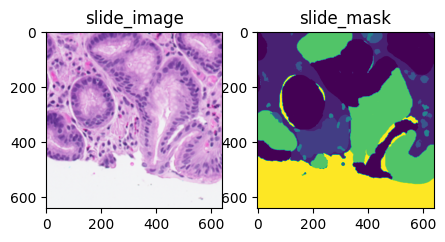

In [ ]:
fig,ax = plt.subplots(1,2,figsize = (5,5))
ax = ax.ravel()
ax[0].imshow(slide_img)
ax[0].set_title('slide_image')
ax[1].imshow(slide_mask[:,:,0])
ax[1].set_title('slide_mask')
plt.show()

In [ ]:
def get_augmented_images(slide_dataset):
  len_dataset = len(slide_dataset)
  transformed_img_list =[]
  transformed_msk_list = []
  print(f"dataset has {len_dataset} images")
  for idx in range(len_dataset):
    slide_img,slide_mask = slide.__getitem__(idx)
    slide_mask = slide_mask[:,:,0]
    #print(f"image shape {slide_img.shape}")
    #print(f"mask shape {slide_mask.shape}")
    transformed_img_list.append(slide_img)
    transformed_msk_list.append(slide_mask)
    # add the augmentations
    for ndx in range(20):
      transformed = t_train(image = slide_img,mask = slide_mask)
      t_sl_img = transformed['image']
      t_sl_msk = transformed['mask']
      transformed_img_list.append(t_sl_img)
      transformed_msk_list.append(t_sl_msk)
    print(f"total images in library {len(transformed_img_list)}")
    print(f"total masks in library {len(transformed_msk_list)}")
    #break
  return transformed_img_list,transformed_msk_list

In [ ]:
transformed_img_list,transformed_msk_list = get_augmented_images(slide_dataset)

dataset has 50 images
total images in library 21
total masks in library 21
total images in library 42
total masks in library 42
total images in library 63
total masks in library 63
total images in library 84
total masks in library 84
total images in library 105
total masks in library 105
total images in library 126
total masks in library 126
total images in library 147
total masks in library 147
total images in library 168
total masks in library 168
total images in library 189
total masks in library 189
total images in library 210
total masks in library 210
total images in library 231
total masks in library 231
total images in library 252
total masks in library 252
total images in library 273
total masks in library 273
total images in library 294
total masks in library 294
total images in library 315
total masks in library 315
total images in library 336
total masks in library 336
total images in library 357
total masks in library 357
total images in library 378
total masks in library 

In [ ]:
for i,pair in enumerate(zip(transformed_img_list,transformed_msk_list)):
  image_name = "img_"+str(i+1)+".png"
  mask_name = "img_"+str(i+1)+".png"
  image_path = os.path.join(AUG_IMG_PATH,image_name)
  mask_path = os.path.join(AUG_MSK_PATH,image_name)
  cv2.imwrite(image_path,pair[0])
  cv2.imwrite(mask_path,pair[1])


In [ ]:
!ls /content/drive/MyDrive/BBB/masks



img_1000.png  img_190.png  img_325.png	img_460.png  img_596.png  img_730.png  img_866.png
img_1001.png  img_191.png  img_326.png	img_461.png  img_597.png  img_731.png  img_867.png
img_1002.png  img_192.png  img_327.png	img_462.png  img_598.png  img_732.png  img_868.png
img_1003.png  img_193.png  img_328.png	img_463.png  img_599.png  img_733.png  img_869.png
img_1004.png  img_194.png  img_329.png	img_464.png  img_59.png   img_734.png  img_86.png
img_1005.png  img_195.png  img_32.png	img_465.png  img_5.png	  img_735.png  img_870.png
img_1006.png  img_196.png  img_330.png	img_466.png  img_600.png  img_736.png  img_871.png
img_1007.png  img_197.png  img_331.png	img_467.png  img_601.png  img_737.png  img_872.png
img_1008.png  img_198.png  img_332.png	img_468.png  img_602.png  img_738.png  img_873.png
img_1009.png  img_199.png  img_333.png	img_469.png  img_603.png  img_739.png  img_874.png
img_100.png   img_19.png   img_334.png	img_46.png   img_604.png  img_73.png   img_875.png
img_1010.png 

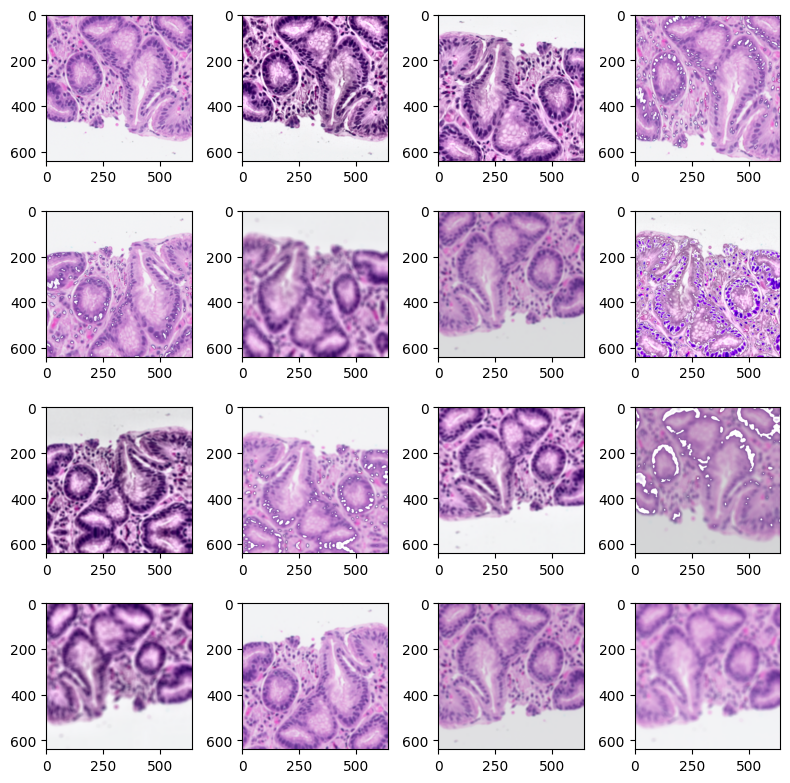

In [ ]:
fig,ax = plt.subplots(4,4,figsize = (8,8))
ax = ax.ravel()
for i in range(16):
  ax[i].imshow(transformed_img_list[i])
fig.tight_layout()
plt.show()

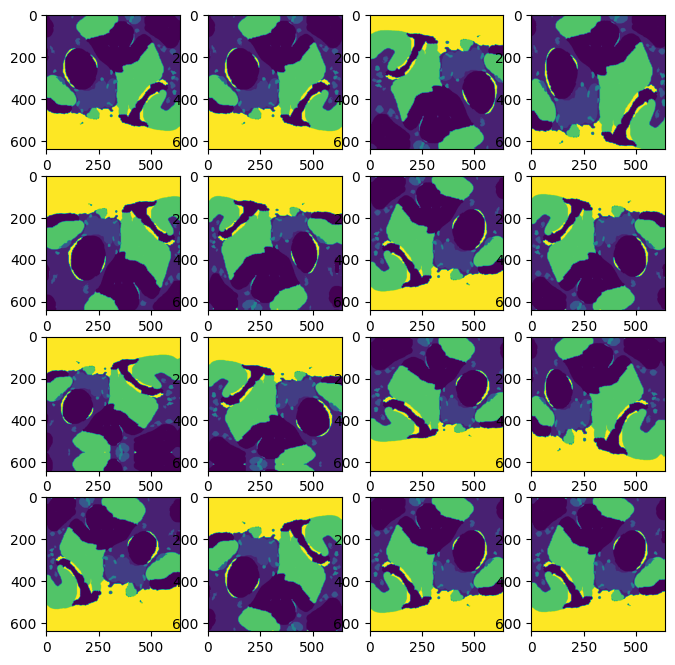

In [ ]:
fig,ax = plt.subplots(4,4,figsize = (8,8))
ax = ax.ravel()
for i in range(16):
  ax[i].imshow(transformed_msk_list[i][:,:,2])
plt.show()